In [25]:
import pytorch_lightning as pl
import torch
import yaml
from Models.ldm import AutoencoderKL
from Data.dataloaders import ABIDELoader
from functools import partial
import einops
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [26]:
with open(r"../Configurations/ABIDE/vae_config.yml", 'r+') as yaml_file:
    ae_config = yaml.safe_load(yaml_file)
model = AutoencoderKL(**ae_config)
model.load_state_dict(
    torch.load(r"/Users/balazsmorvay/Downloads/epoch=51-step=75500.ckpt", map_location='cpu')['state_dict'])
model.to(device='cpu')
model.eval()

making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
Working with z of shape (1, 4, 16, 16) = 1024 dimensions.
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(61, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(8, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(8, 64, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(8, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNo

In [27]:
transforms = {
    'fmri': [
        partial(einops.rearrange, pattern='b h l d -> b 1 d h l'),
        partial(F.pad, pad=(0, 0, 3, 3))
    ]
}

batch_size = 1
datahandler = ABIDELoader(
    root_dir=r"/Users/balazsmorvay/Downloads/ABIDE/data/Outputs/ccs/filt_noglobal/func_preproc",
    exp_path=r"../Configurations/ABIDE/",
    batch_size=batch_size,
    transforms=transforms,
    rescale=True,
    num_workers=0,
    prefetch_factor=None,
    persistent_workers=None
)
trainer = pl.Trainer()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


  0%|          | 0/2957 [00:00<?, ?it/s]


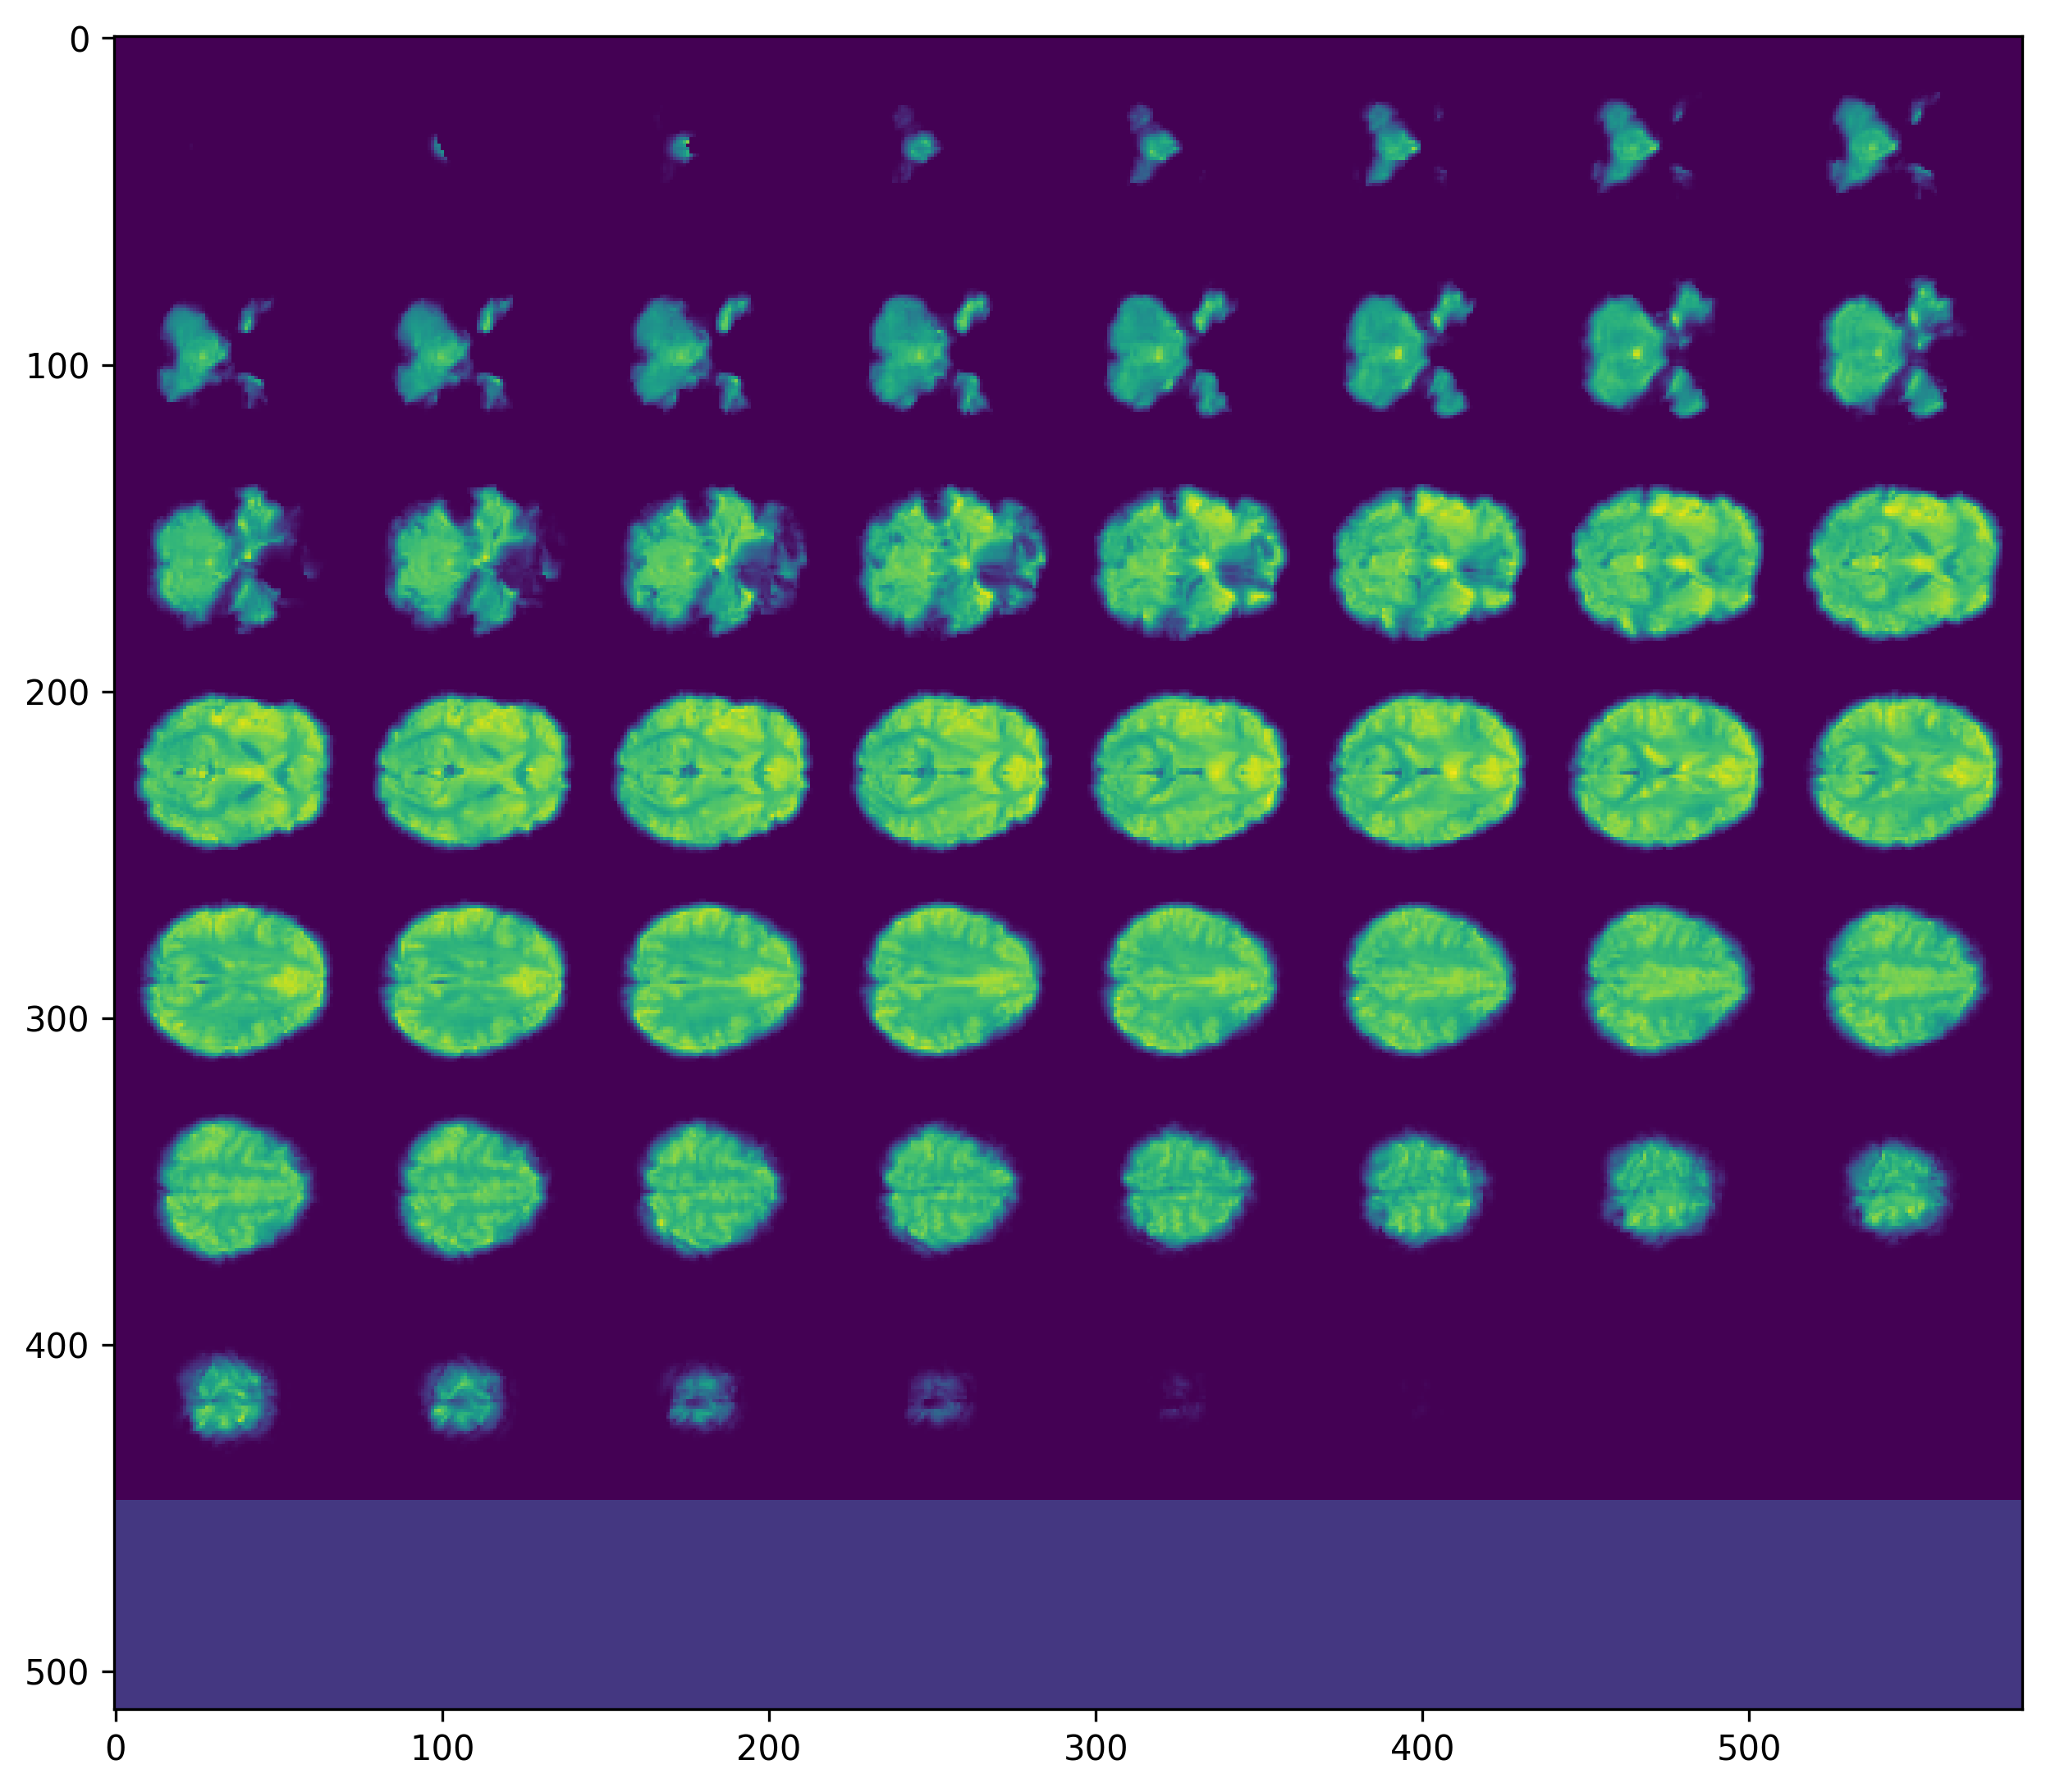

In [28]:
from skimage.util import montage

datahandler.setup('test')
dataloader = datahandler.test_dataloader()

with torch.inference_mode():
    for i in tqdm(range(len(dataloader))):
        inp = next(iter(dataloader))
        inp = datahandler.on_after_batch_transfer(inp, i)
        inp_fmri = model.get_input(inp, 'fmri')
        outp = model.encode(inp_fmri.squeeze(0)).mode().cpu()
        outp = (outp - outp.min()) / (outp.max() - outp.min()) * 2 - 1

        plt.figure(figsize=(3000/300, 3000/300), dpi=300)
        plt.imshow(montage(inp_fmri[0, 0, :56, :-3].cpu()))
        break

In [30]:
outp.shape

torch.Size([1, 4, 16, 18])

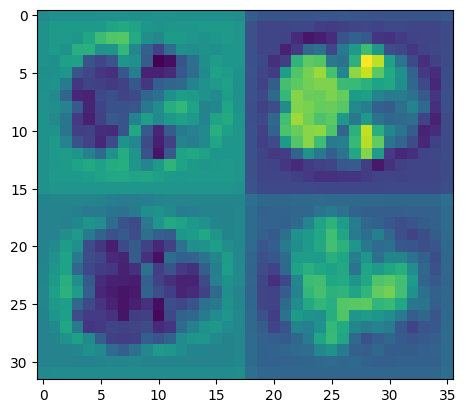

In [40]:
plt.imshow(montage(outp[0].cpu()))

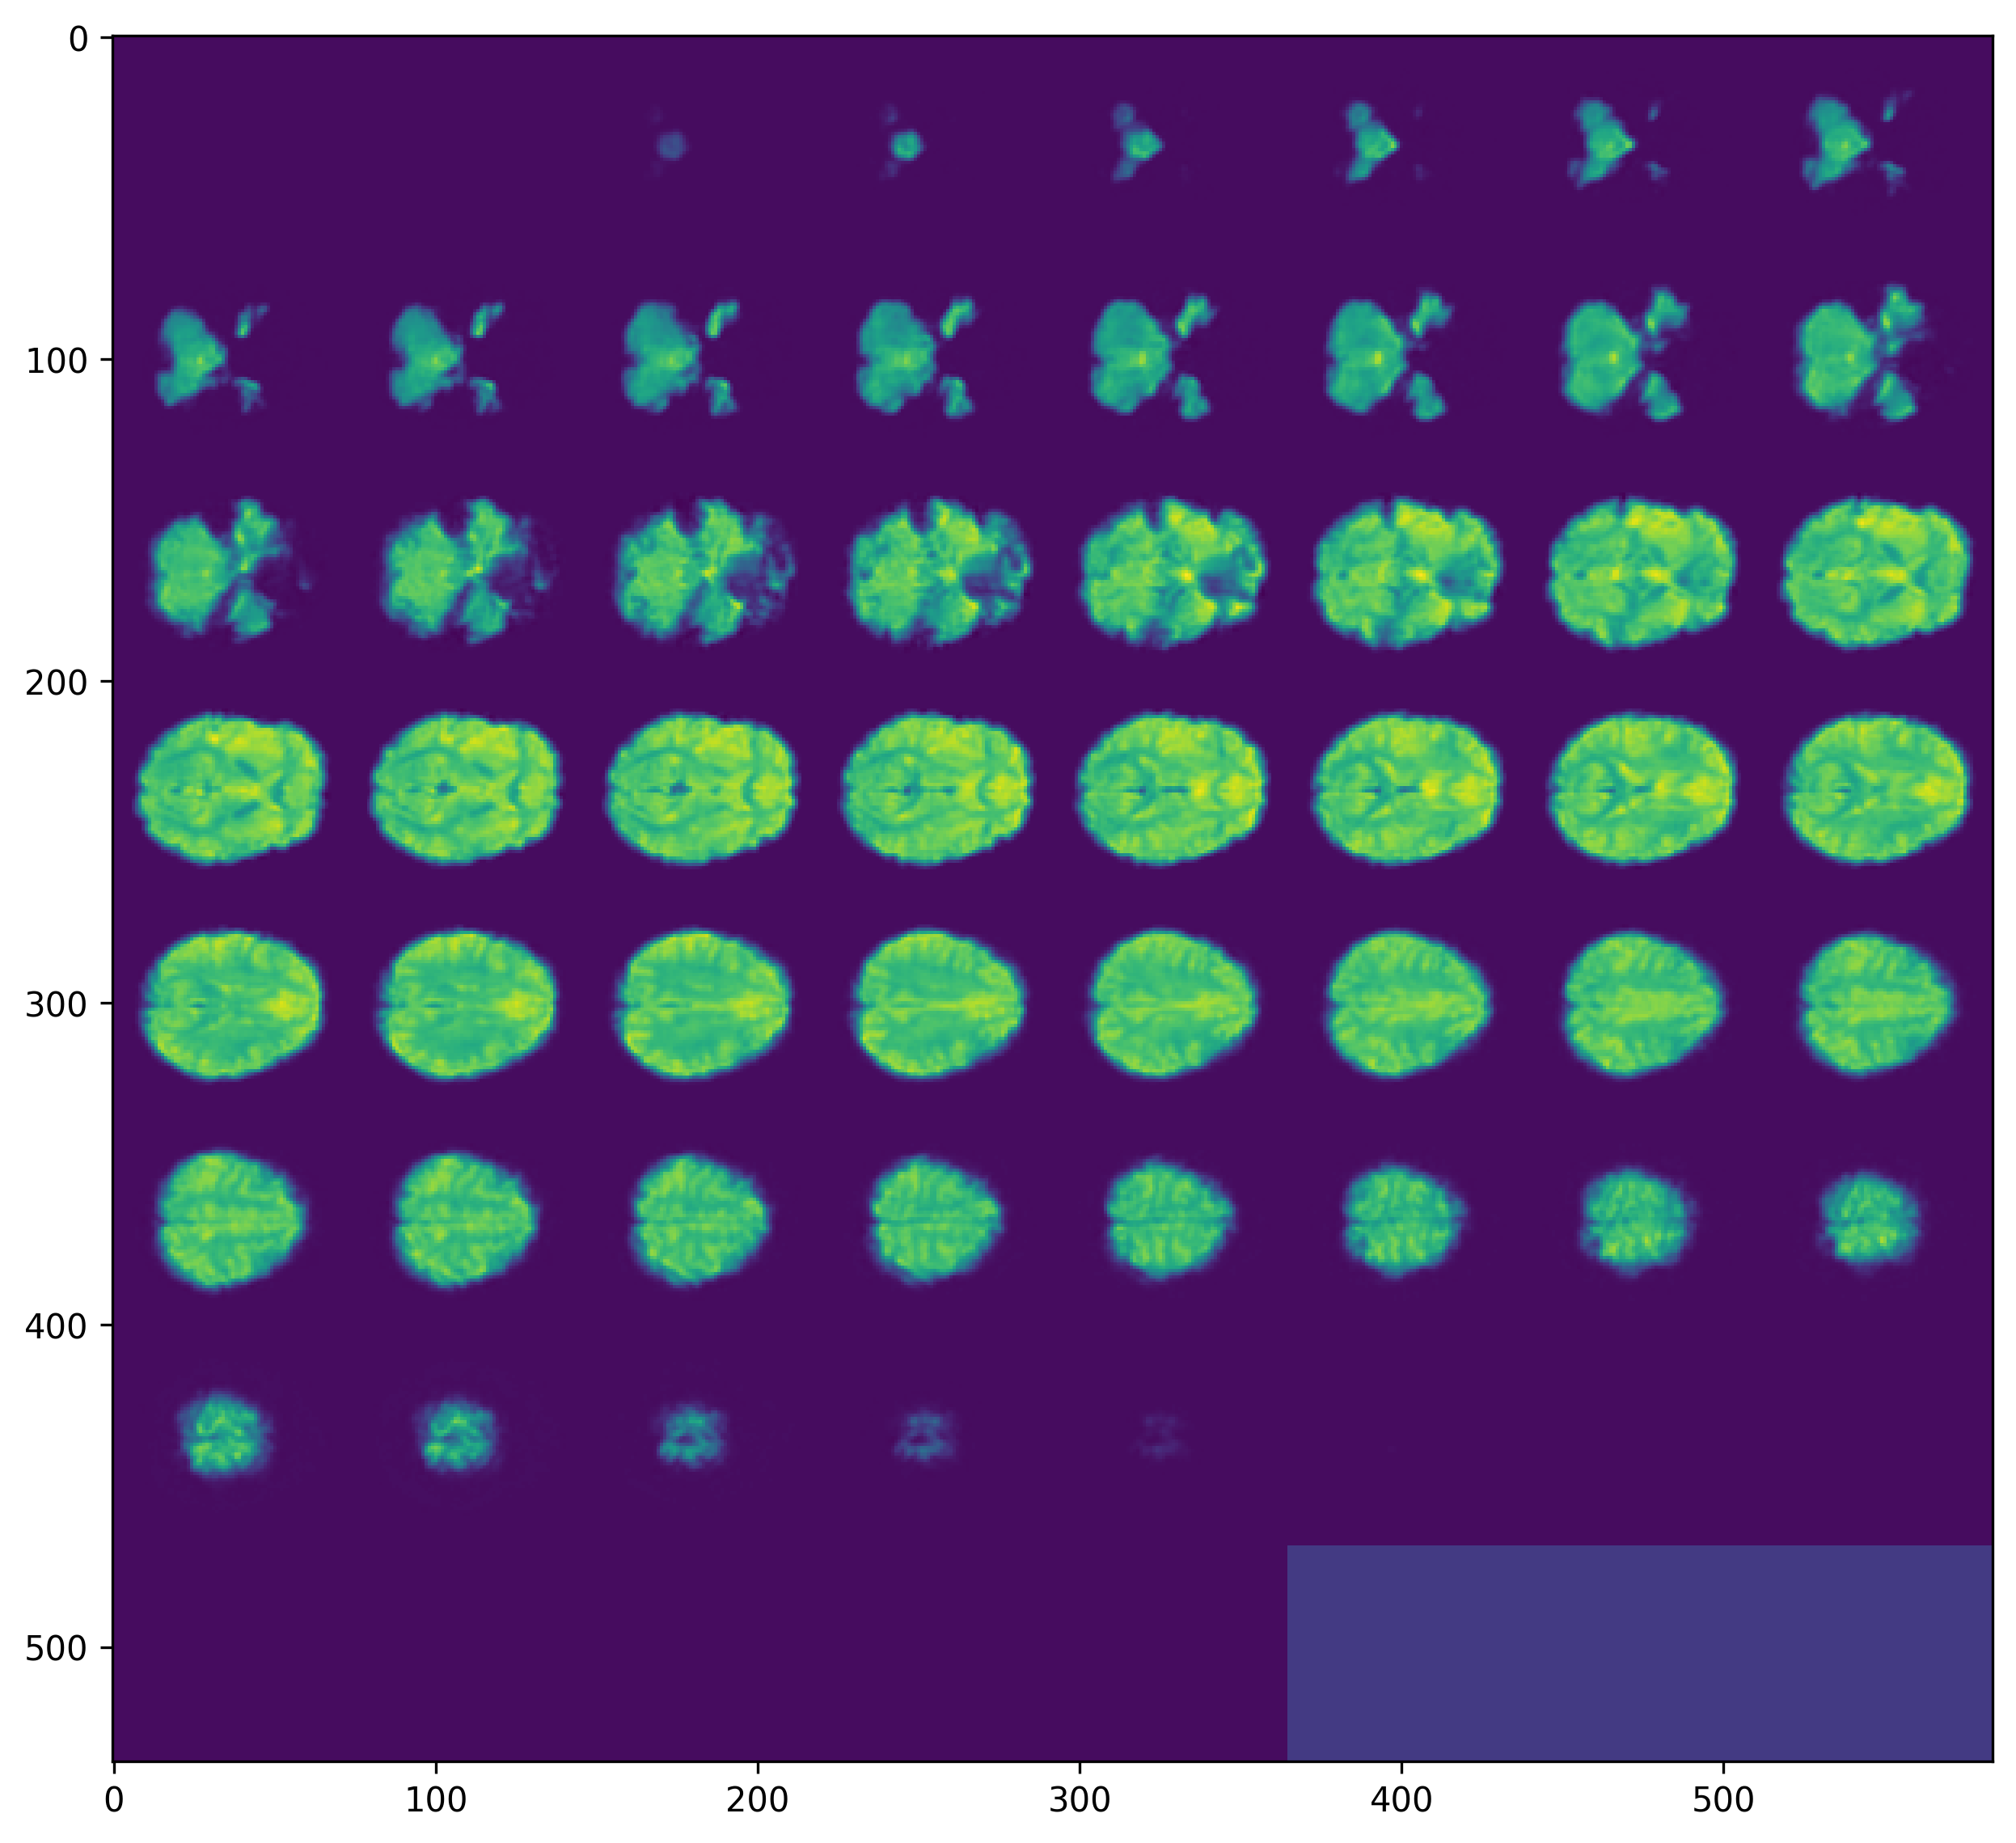

In [35]:
plt.figure(figsize=(3000/300, 3000/300), dpi=300)

with torch.inference_mode():
    decoded = model.decode(outp.cpu())
plt.imshow(montage(decoded[0].cpu()))